In [1]:
import sys

sys.path.append('../src')
from lda import GibbsLDA
from sim import POLYGONS, make_dataset
from slda import GibbsSLDA
from util import map_labels, show_dataset

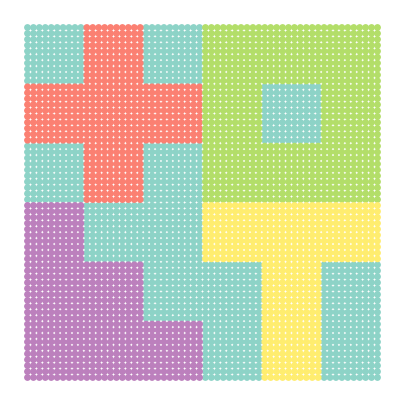

In [2]:
data, labels = make_dataset()
show_dataset(data, labels)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def activation(act='relu', **kwargs):
    if act == 'relu':
        return nn.ReLU(**kwargs)
    elif act == 'prelu':
        return nn.PReLU(**kwargs)
    elif act == 'softplus':
        return nn.Softplus(**kwargs)
    elif act == 'sigmoid':
        return nn.Sigmoid(**kwargs)
    elif act == 'tanh':
        return nn.Tanh(**kwargs)
    
    raise NotImplementedError(f'Activation "{act}" not supported.')

def layer(input_dim, output_dim, bias=True, batch_norm=False, act='relu', dropout=0.):
    yield nn.Linear(input_dim, output_dim, bias=bias)

    if batch_norm:
        yield nn.BatchNorm1d(output_dim)

    if act is not None:
        yield activation(act)

    if dropout > 0.:
        yield nn.Dropout(dropout)

def mlp(layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
    n_layers = len(layers)
    net = []

    for i in range(1, n_layers):
        if i < n_layers - 1:
            yield from layer(layers[i - 1], layers[i], bias, batch_norm, act, dropout)
        else:
            yield from layer(layers[i - 1], layers[i], final_bias, final_norm, final_act, final_drop)

class MLP(nn.Module):
    def __init__(self, layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
        super().__init__()

        self.net = nn.Sequential(*list(mlp(layers, bias, final_bias, batch_norm, final_norm, act, final_act, dropout, final_drop)))

    def forward(self, x):
        y = self.net(x)

        return y

class Encoder(nn.Module):
    def __init__(self, h_layers, g_layers, u_layers, f_layers):
        super().__init__()

        self.h_net = MLP(h_layers, batch_norm=True, act='prelu')
        self.g_net = MLP(g_layers, batch_norm=True, act='prelu')
        self.u_net = MLP(u_layers, batch_norm=True, act='prelu')
        self.f_net = MLP(f_layers, final_bias=False, batch_norm=True, act='prelu')

    def forward(self, data):        
        h, u = self.h_net(data), self.u_net(data)
        U, K = u[1:].sum(0)[None].repeat(100, 1), 1
        H = torch.zeros((100, h.shape[-1]))
        H[0, :] = h[0]
        G = self.g_net(H[0])
        Gk = torch.zeros((100, G.shape[-1]))
        c = torch.zeros(data.shape[0], dtype=torch.int32)
        q = torch.zeros((data.shape[0], 100))

        for n in range(1, data.shape[0]):
            U = U - u[n]

            Gk[:K + 1] = G + self.g_net(H[:K + 1] + h[n]) - self.g_net(H[:K + 1])
            q[n, :K + 1] = self.f_net(torch.hstack([Gk[:K + 1], U[:K + 1]])).flatten()
            c[n] = torch.multinomial(q[n, :K + 1].exp(), 1)
            # c[n] = q[n, :K + 1].argmax()

            if c[n] == K:
                K += 1

            G = G - self.g_net(H[c[n]]) + self.g_net(H[c[n]] + h[n])
            H = H + torch.vstack([torch.zeros((c[n], h.shape[-1])), h[n][None], torch.zeros((H.shape[0] - c[n] - 1, h.shape[-1]))])

        return c, q[:, :K + 1]
    
class NCP(nn.Module):
    def __init__(self, h_layers, g_layers, u_layers, f_layers):
        super().__init__()

        self.encoder = Encoder(h_layers, g_layers, u_layers, f_layers)

        self.loss_log = []

    def train(self, data, n_steps=100, learning_rate=1e-4):
        optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
        x = torch.arange(data.shape[0])

        for i in tqdm(range(n_steps)):
            l = 0
            for _ in range(1):
                idx = torch.randperm(data.shape[0])
                c, logprobs = self.encoder(data[idx])
                loss = -logprobs[x, c].mean()
                loss.backward()
                l += loss.item()
            self.loss_log.append(l)
            optimizer.step()
            optimizer.zero_grad()

        return self

In [ ]:
h_layers = [data.shape[-1] - 3, 75]
g_layers = [75, 25]
u_layers = [data.shape[-1] - 3, 75, 25]
f_layers = [50, 25, 25, 1]

model = NCP(h_layers, g_layers, u_layers, f_layers).train(data[:, 3:])
c, _ = model.encoder(data[:, 3:])
show_dataset(data, c)
plt.show()
x = np.arange(len(model.loss_log))
plt.plot(x, model.loss_log)
plt.show()